In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from transformers import TFViTModel, ViTConfig
import logging
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
logging.basicConfig(level=logging.INFO)

d:\Aayush\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


def load_pretrained_vit(model_names):
    for name in model_names:
        try:
            vit = TFViTModel.from_pretrained(name)
            logging.info(f"Loaded ViT weights from '{name}'")
            return vit
        except Exception as e:
            logging.warning(f"could not load '{name}': {e}")
    raise RuntimeError(f"No pretrained ViT found among: {model_names}")

In [3]:


class ViTBackbone(Model):
    def __init__(self, image_size=224, patch_size=16):
        super().__init__()
        self.patch_size = patch_size
        hf_models = [
            "nateraw/vit-base-patch16-224-cifar10",
            "Ahmed9275/Vit-Cifar100",
            "google/vit-base-patch16-224-in21k",
        ]
        self.base_model = load_pretrained_vit(hf_models)
        self.base_model.trainable = False
        cfg = self.base_model.config
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = cfg.hidden_size

    def call(self, x, training=False):
        x = tf.transpose(x, perm=[0, 3, 1, 2])
        out = self.base_model(pixel_values=x, training=training)
        return out.last_hidden_state[:, 1:, :]

In [4]:


class PatchWeightingAgent(Model):
    def __init__(self, patch_dim, num_patches):
        super().__init__()
        self.flat_dim = patch_dim * num_patches
        self.net = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(num_patches),
        ])

    def call(self, patches, training=False):
        b = tf.shape(patches)[0]
        flat = tf.reshape(patches, (b, self.flat_dim))
        logits = self.net(flat)
        return tf.nn.softmax(logits, axis=-1)

In [5]:


class RLViT(Model):
    def __init__(self, image_size=224, patch_size=16, num_classes=10):
        super().__init__()
        self.vit = ViTBackbone(image_size, patch_size)
        self.agent = PatchWeightingAgent(self.vit.patch_dim, self.vit.num_patches)
        self.classifier = layers.Dense(num_classes)

    def call(self, images, training=False):
        patches = self.vit(images, training=training)
        w = self.agent(patches, training=training)
        w_exp = tf.expand_dims(w, -1)
        weighted = patches * w_exp
        pooled = tf.reduce_sum(weighted, axis=1)
        logits = self.classifier(pooled)
        return logits, w

In [6]:


class RLTrainer:
    def __init__(self, model, optimizer):
        self.epoch_train_loss = []
        self.epoch_train_acc = []
        self.epoch_test_acc = []
        self.model = model
        self.opt = optimizer
        self.ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc')
        self.test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')

    def compute_loss(self, labels, logits, weights):
        c_loss = self.ce(labels, logits)
        preds = tf.argmax(logits, axis=-1, output_type=tf.int32)
        labels = tf.cast(labels, tf.int32)  # Ensure matching type for comparison
        rewards = tf.cast(tf.equal(preds, labels), tf.float32)
        logp = tf.reduce_sum(tf.math.log(weights + 1e-10), axis=-1)
        p_loss = -tf.reduce_mean(logp * rewards)
        entropy = -tf.reduce_sum(weights * tf.math.log(weights + 1e-10), axis=-1)
        e_bonus = 0.01 * tf.reduce_mean(entropy)
        return c_loss + p_loss - e_bonus, c_loss, p_loss, e_bonus

    @tf.function
    def train_step(self, images, labels):
        with tf.GradientTape() as tape:
            logits, weights = self.model(images, training=True)
            loss, cl, pl, eb = self.compute_loss(labels, logits, weights)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        self.train_loss.update_state(loss)
        self.train_acc.update_state(labels, logits)
        return loss, cl, pl, eb

    @tf.function
    def test_step(self, images, labels):
        logits, _ = self.model(images, training=False)
        self.test_acc.update_state(labels, logits)

    def train(self, train_ds, test_ds, epochs=5):
        for ep in range(1, epochs + 1):
            self.train_loss.reset_state()
            self.train_acc.reset_state()
            self.test_acc.reset_state()
            for step, (imgs, lbls) in enumerate(train_ds):
                l, cl, pl, eb = self.train_step(imgs, lbls)
                if step % 100 == 0:
                    print(f"[E{ep} S{step}] loss={l:.4f}, ce={cl:.4f}, pg={pl:.4f}, ent={eb:.4f}, acc={self.train_acc.result():.4f}")
            for imgs, lbls in test_ds:
                self.test_step(imgs, lbls)
            # Log metrics
            self.epoch_train_loss.append(self.train_loss.result().numpy())
            self.epoch_train_acc.append(self.train_acc.result().numpy())
            self.epoch_test_acc.append(self.test_acc.result().numpy())
            print(f"→ E{ep} TrainAcc: {self.train_acc.result():.4f}, TestAcc: {self.test_acc.result():.4f}")
            
    def plot_metrics(self):
        epochs = range(1, len(self.epoch_train_loss) + 1)
        plt.figure(figsize=(12, 6))
        
        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.epoch_train_loss, label='Train Loss')
        plt.title('Loss vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.epoch_train_acc, label='Train Accuracy')
        plt.plot(epochs, self.epoch_test_acc, label='Test Accuracy')
        plt.title('Accuracy vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def visualize_patch_weights(self, images, num_samples=5):
        _, weights = self.model(images[:num_samples], training=False)
        imgs = (images[:num_samples].numpy() + 1) / 2.0
        gs = images.shape[1] // self.model.vit.patch_size
        plt.figure(figsize=(12, 4 * num_samples))
        for i in range(num_samples):
            wgrid = weights[i].numpy().reshape(gs, gs)
            plt.subplot(num_samples, 3, 3 * i + 1)
            plt.imshow(imgs[i])
            plt.title(f"Img {i}")
            plt.axis('off')
            plt.subplot(num_samples, 3, 3 * i + 2)
            plt.imshow(wgrid, cmap='hot')
            plt.title("Weights")
            plt.axis('off')
            wm = tf.image.resize(wgrid[..., None], (images.shape[1], images.shape[2]))[..., 0].numpy()
            cm = plt.cm.hot(wm)[..., :3]
            ov = np.clip(0.5 * imgs[i] + 0.5 * cm, 0, 1)
            plt.subplot(num_samples, 3, 3 * i + 3)
            plt.imshow(ov)
            plt.title("Overlay")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

In [7]:
# Add this function to evaluate the model
def evaluate_model(trainer, test_ds, class_names):
    """Evaluates the model and displays a confusion matrix and classification report."""
    y_true = []
    y_pred = []

    # Collect true labels and predictions
    for images, labels in test_ds:
        logits, _ = trainer.model(images, training=False)
        predictions = tf.argmax(logits, axis=-1).numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(predictions)

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [8]:
def prepare_dataset(batch_size=32):
    ds, info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)
    image_size = 224
    def _prep(img, lbl):
        img = tf.image.resize(img, (image_size, image_size))
        img = tf.cast(img, tf.float32) / 255.0
        return img * 2.0 - 1.0, lbl
    train = ds[0].map(_prep, tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test = ds[1].map(_prep, tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train, test, info.features['label'].num_classes


In [9]:
train_ds, test_ds, num_classes = prepare_dataset(32)
model = RLViT(224, 16, num_classes)
opt = tf.keras.optimizers.Adam(3e-4)
trainer = RLTrainer(model, opt)


INFO:absl:Load dataset info from C:\Users\LOQ\tensorflow_datasets\cifar10\3.0.2
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\LOQ\tensorflow_datasets\cifar10\3.0.2.
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\LOQ\tensorflow_datasets\cifar10\3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split ['train', 'test'], from C:\Users\LOQ\tensorflow_datasets\cifar10\3.0.2



All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.
INFO:root:Loaded ViT weights from 'google/vit-base-patch16-224-in21k'


In [10]:
trainer.train(train_ds, test_ds, epochs=3)

[E1 S0] loss=34.6814, ce=2.3575, pg=32.3766, ent=0.0527, acc=0.0312
[E1 S100] loss=971.3638, ce=1.5476, pg=969.8690, ent=0.0528, acc=0.5860
[E1 S200] loss=970.8132, ce=1.0105, pg=969.8555, ent=0.0528, acc=0.7500
[E1 S300] loss=970.6196, ce=0.8137, pg=969.8588, ent=0.0528, acc=0.8157
[E1 S400] loss=938.0651, ce=0.5927, pg=937.5253, ent=0.0528, acc=0.8472
[E1 S500] loss=970.2648, ce=0.4635, pg=969.8542, ent=0.0528, acc=0.8696
[E1 S600] loss=1002.5319, ce=0.4026, pg=1002.1821, ent=0.0528, acc=0.8831
[E1 S700] loss=1034.7634, ce=0.3057, pg=1034.5105, ent=0.0528, acc=0.8927
[E1 S800] loss=1002.4605, ce=0.3307, pg=1002.1826, ent=0.0528, acc=0.9015
[E1 S900] loss=970.1751, ce=0.3612, pg=969.8666, ent=0.0528, acc=0.9080
[E1 S1000] loss=937.7885, ce=0.3162, pg=937.5251, ent=0.0528, acc=0.9130
[E1 S1100] loss=1034.6726, ce=0.1744, pg=1034.5510, ent=0.0528, acc=0.9173
[E1 S1200] loss=937.7682, ce=0.2957, pg=937.5253, ent=0.0528, acc=0.9209
[E1 S1300] loss=1002.3375, ce=0.2081, pg=1002.1823, ent=0

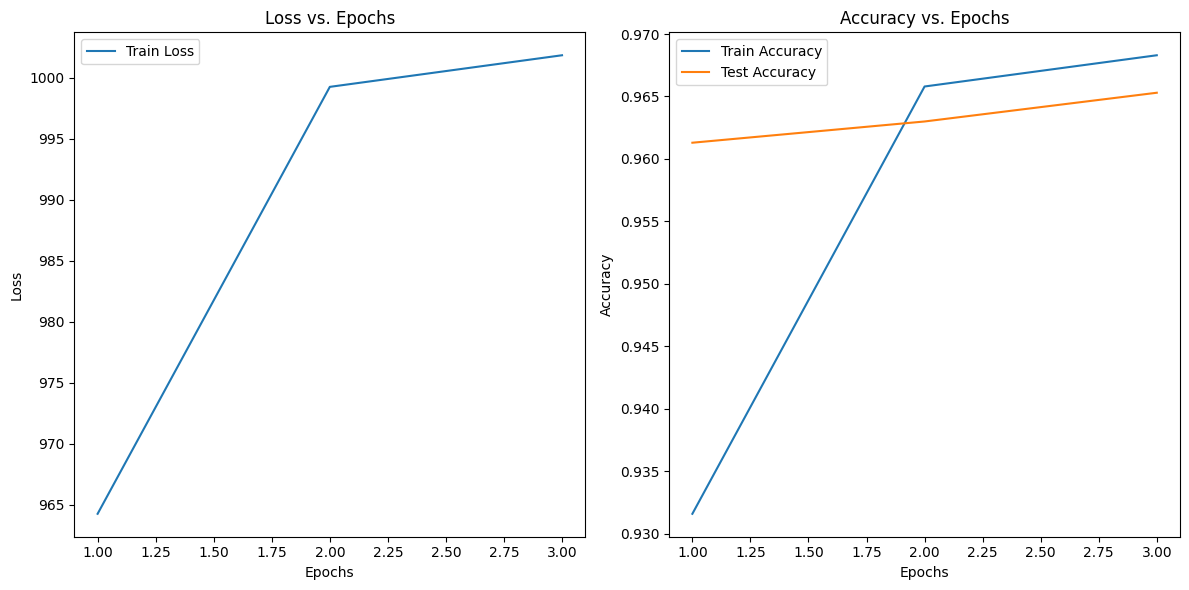

In [11]:
trainer.plot_metrics()

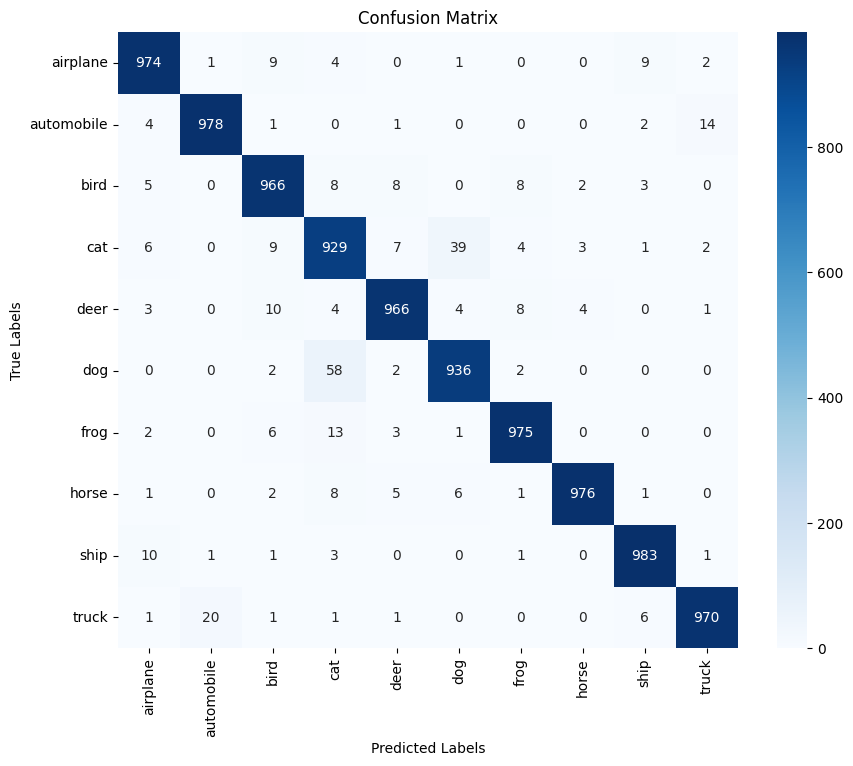

Classification Report:
              precision    recall  f1-score   support

    airplane       0.97      0.97      0.97      1000
  automobile       0.98      0.98      0.98      1000
        bird       0.96      0.97      0.96      1000
         cat       0.90      0.93      0.92      1000
        deer       0.97      0.97      0.97      1000
         dog       0.95      0.94      0.94      1000
        frog       0.98      0.97      0.98      1000
       horse       0.99      0.98      0.98      1000
        ship       0.98      0.98      0.98      1000
       truck       0.98      0.97      0.97      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [12]:
# Evaluate the model
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
evaluate_model(trainer, test_ds, class_names)

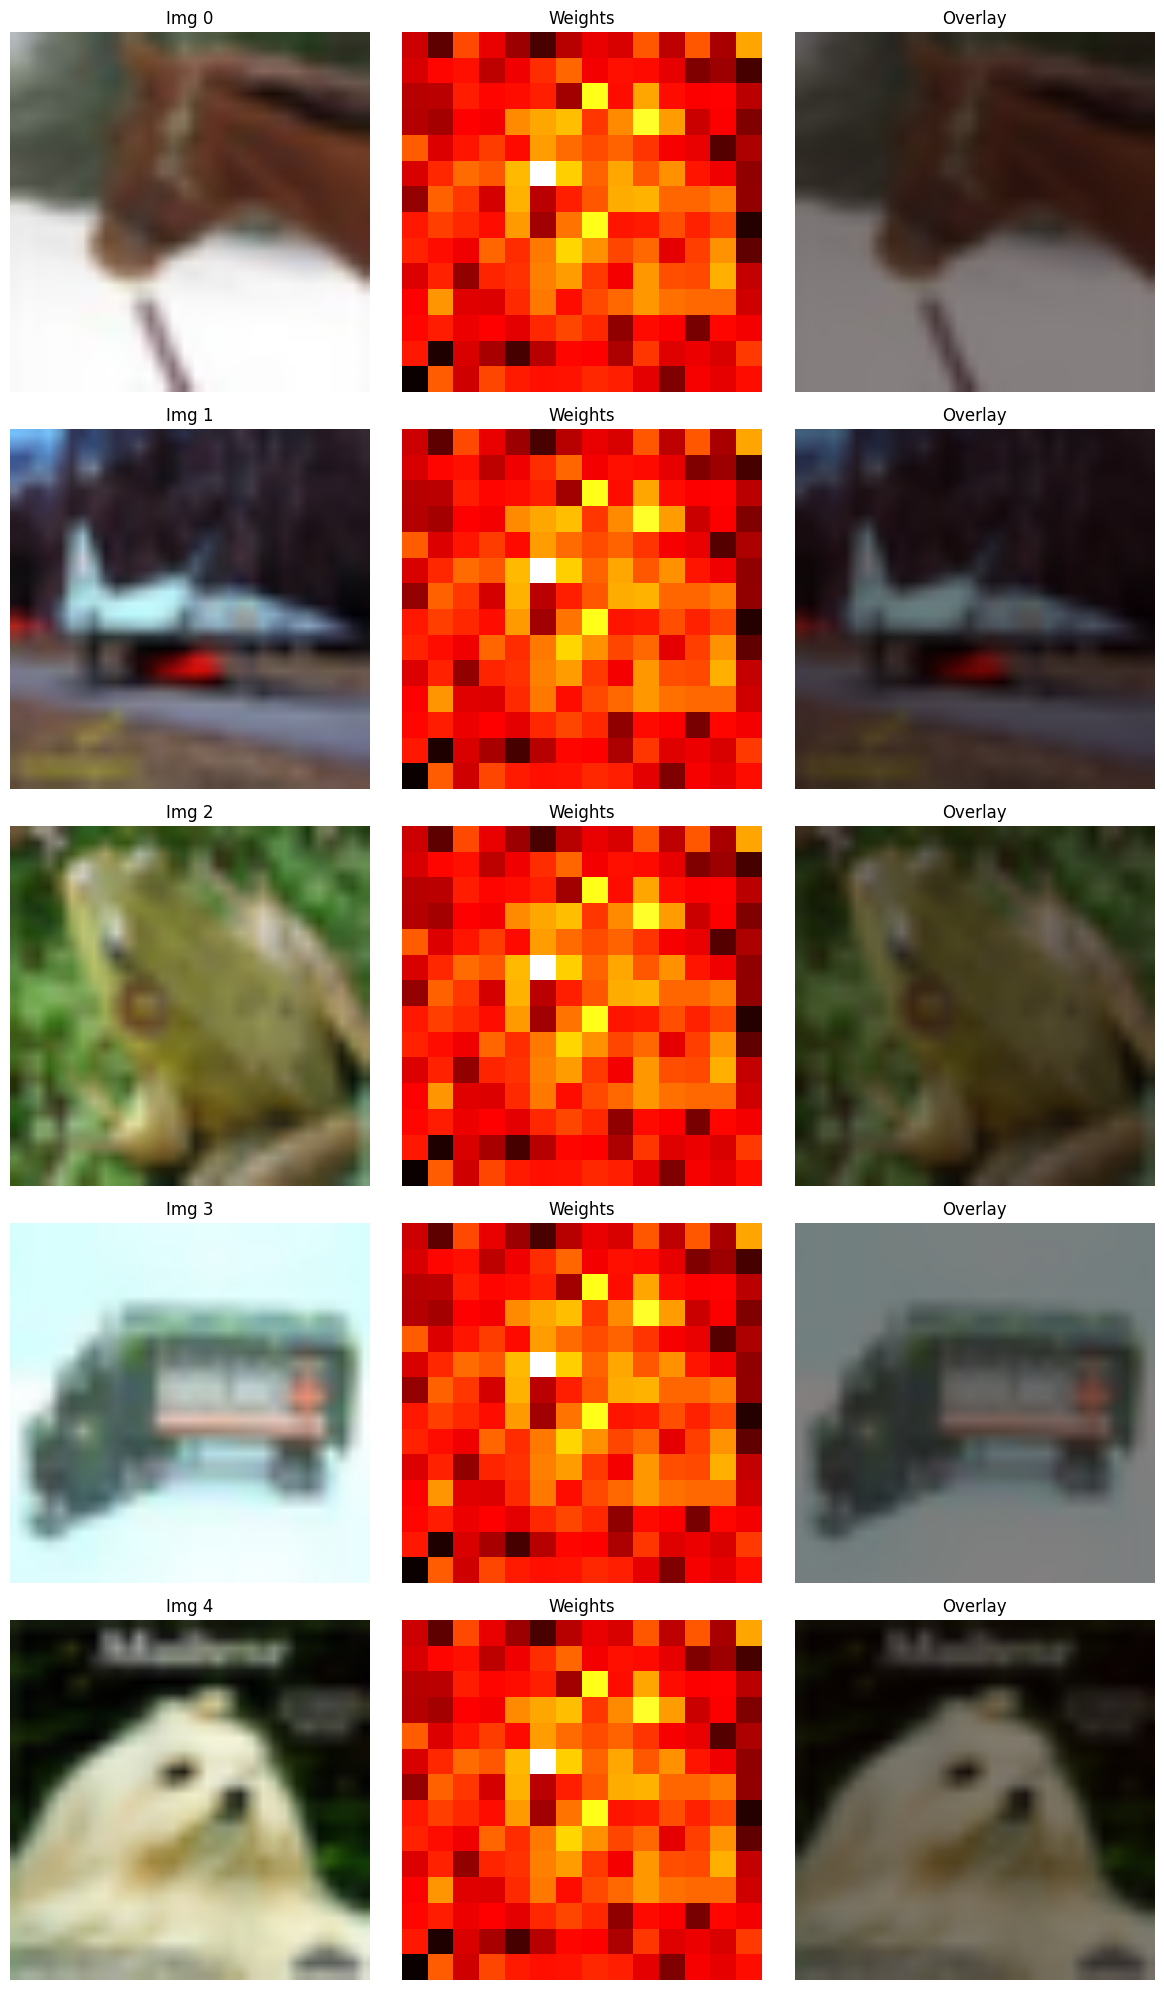

In [13]:
for imgs, _ in test_ds.take(1):
    trainer.visualize_patch_weights(imgs)
    break

In [15]:
model.save('/rl_vit.h5')
print("Saved model.")

Saved model.
